In [1]:
## local path to vp_tree library. 
## Available at https://github.com/tabakg/cpp/tree/master/vp_trees_with_python_interface

import sys
sys.path.append("/Users/gil/Documents/repos/c_pp_stuff/vp_trees_with_python_interface")
import vp_tree

## numerical librarires
import numpy as np
from numpy import linalg as la
from numpy.random import normal
import random

import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs

from sklearn.decomposition import FastICA

## graphing
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## misc
import time
from ipywidgets import interact
import pickle

In [2]:
from diffusion_maps import make_gaussian_data
from diffusion_maps import run_diffusion_map
from diffusion_maps import generate_data_n_gaussians

In [3]:
printing_calculations = False

In [4]:
params = {}

params["mus"] = [0.,-6.,6.] ## data distribution mean.
params["sigma"] = 1.0 ## data distribution standard deviation.
params["epsilon"] = 3. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 3. ## width of Gaussian kernel.
params["alpha"] = 0.5 ## coefficient to use for diffusion maps. See the wikipedia article.

params["dim"] = 1 ## number of dimensions in which to generate data
params["data_size"] = 300 ## total number of points
params["n"] = 3 ## for n_gaussians, number of gaussian wells
params["eigen_dims"] = 4  ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

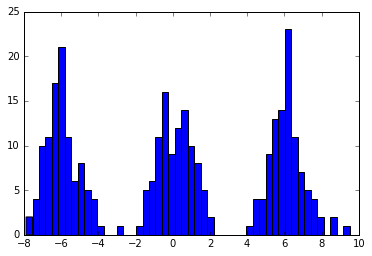

In [5]:
## Make three well-separated Gaussians

data = generate_data_n_gaussians(params)
data.sort(key = lambda z: z[0] / abs(z[0]) * np.sqrt(sum([el**2 for el in z])))
plt.hist([el[0] for el in np.asarray(data)],bins=50);

[ 1.          0.99712166  0.98996247  0.33994384]


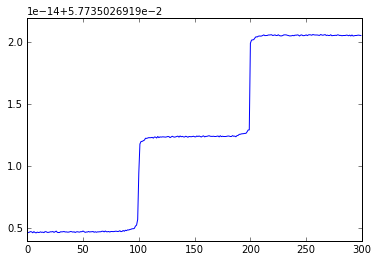

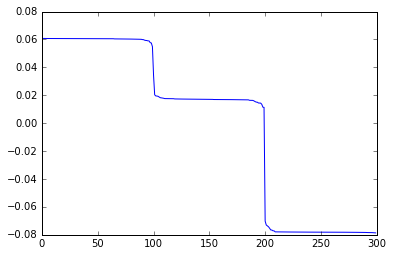

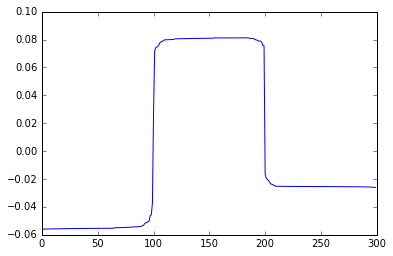

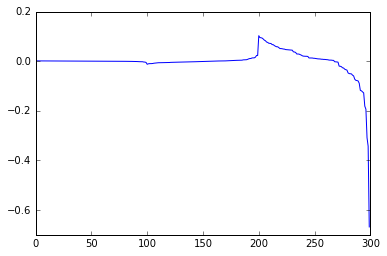

In [6]:
## alpha == 0.5 case. This corresponds to a diffusion.

params["alpha"] = 0.5 ## coefficient to use for diffusion maps. See the wikipedia article.
e_vals, e_vecs = run_diffusion_map(data, params)

e_vals / la.norm(e_vals)
print e_vals
for vec in e_vecs.T:
    plt.plot(vec)
    plt.show()

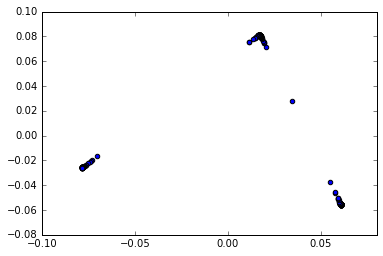

In [7]:
plt.scatter(e_vecs.T[1],e_vecs.T[2])

[ 1.          0.99635913  0.98664325  0.47243907]


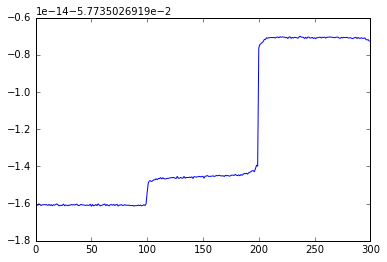

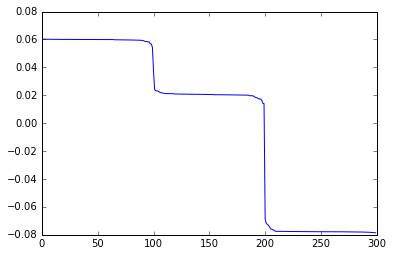

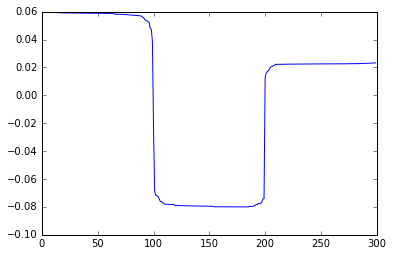

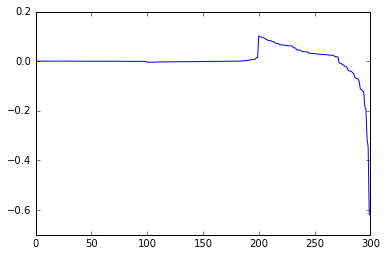

In [8]:
## alpha == 1 case finds coordinates regardless of probability density.

params["alpha"] = 1.0 ## coefficient to use for diffusion maps. See the wikipedia article.
e_vals, e_vecs = run_diffusion_map(data, params)
e_vals / la.norm(e_vals)
print e_vals
for vec in e_vecs.T:
    plt.plot(vec)
    plt.show()

Something fun to try for the $\alpha = 1$ case at least:

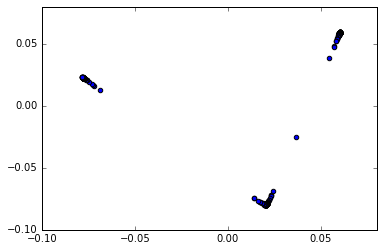

In [9]:
plt.scatter(e_vecs.T[1],e_vecs.T[2])

[ 1.          0.99777545  0.99246407  0.26063877]


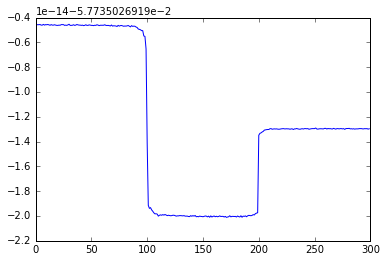

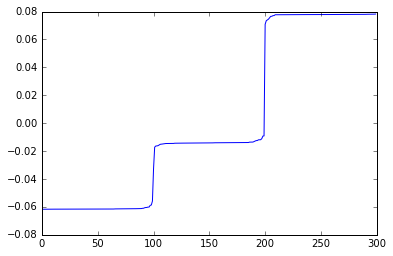

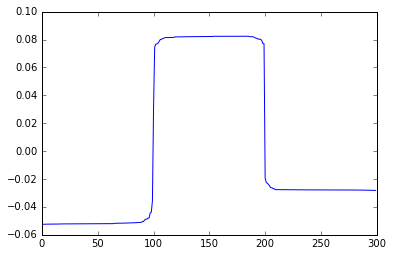

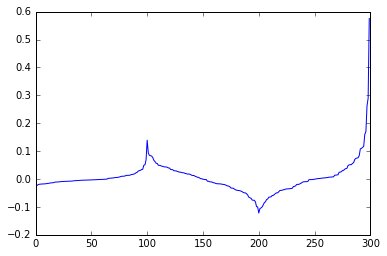

In [10]:
## Finally, alpha == 0 is the 

params["alpha"] = 0.0 ## coefficient to use for diffusion maps. See the wikipedia article.
e_vals, e_vecs = run_diffusion_map(data, params)
e_vals / la.norm(e_vals)
print e_vals

for vec in e_vecs.T:
    plt.plot(vec)
    plt.show()

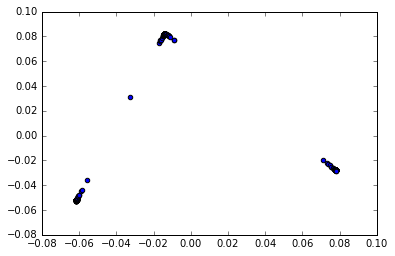

In [11]:
plt.scatter(e_vecs.T[1],e_vecs.T[2])

## 1D experiment

Let's replicate example 1 in http://pca.narod.ru/10MainGorbanKeglWunschZin.pdf

Furthermore, let's see what happens as we change the radius $epsilon$ to see how the results depend on the radius of the Gaussian chosen.

The average distance between points is 0.0833. Below we experiment with different values of the Gaussian radius. 

In [103]:
from mpl_toolkits.mplot3d import Axes3D

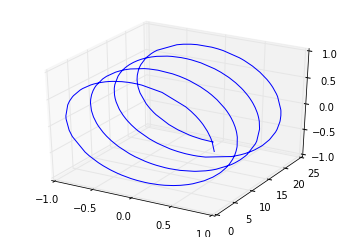

In [165]:
t = sorted([random.uniform(0, 15*np.pi/2) for i in range(400)])
xs,ys,zs = list(np.cos(t)), list(t), list(np.sin(t))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs, ys, zs)

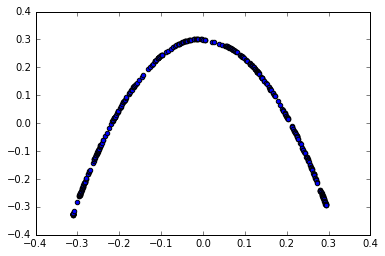

In [166]:
data = [[x,y,z] for x,y,z in zip(xs,ys,zs)]

params = {}
params["epsilon"] = 1. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 0.5 ## width of Gaussian kernel.
params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

params["data_size"] = 400
params["eigen_dims"] = 3

e_vals, e_vecs = run_diffusion_map(data, params,True)
v1,v2,v3 = (e_vecs.T)[0:3]
plt.scatter(v2,v3)

## We can explore how the $\phi_2$ vs $\phi_1$ graphs change.

In [170]:
def make_vecs(gauss_eps):
    params = {}
    params["epsilon"] = 1. ## cutoff for nearest neighbors.
    params["gaussian_epsilon"] = gauss_eps ## width of Gaussian kernel.
    params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

    params["data_size"] = 400
    params["eigen_dims"] = 3

    e_vals, e_vecs = run_diffusion_map(data, params)
    v1,v2,v3 = (e_vecs.T)[0:3]
    return v2,v3

In [173]:
stepping_tuple = low,high,inter = 0,20,1
D = {i:val for i,val in enumerate(np.linspace(0.02,0.05,high + 1))}

In [174]:
plot_scatter = {}
for i in D.keys():
    plot_scatter[i] = make_vecs(D[i])

In [175]:
def plot_scatter_saved(i):
    v2,v3 = plot_scatter[i]
    plt.figure(figsize=(10,10))    
    plt.scatter(v2,v3)
    plt.show()

In [176]:
F = lambda i: plot_scatter_saved(i)

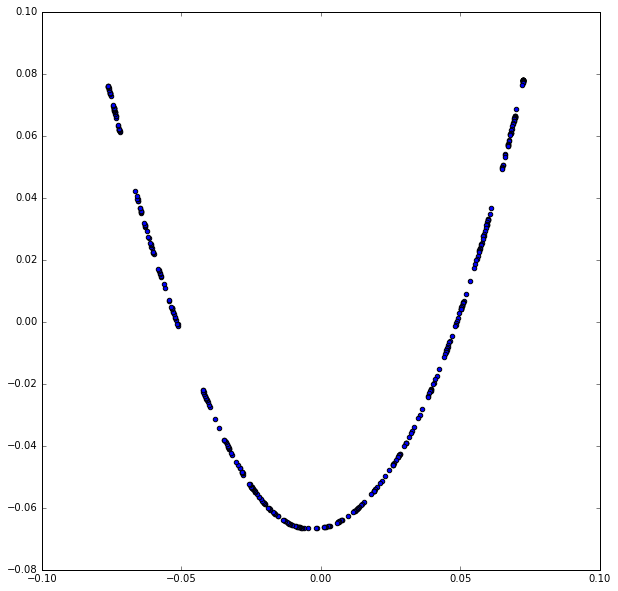

In [177]:
interact(F, i=stepping_tuple )

In [ ]:
## write to file
pickle.dump( plot_scatter, open( "scatterplots.p", "wb" ) )

In [22]:
## read from file
plot_scatter = pickle.load( open( "scatterplots.p", "rb" ) )

## Swiss roll (also used as an example in http://pca.narod.ru/10MainGorbanKeglWunschZin.pdf)

## Non-degenerate case, H = 50


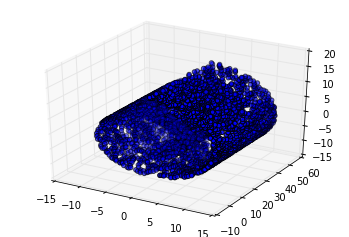

In [24]:

H = 50.
num_points = 5000

t = sorted([random.uniform(3.*np.pi/2., 9.*np.pi/2) for i in range(num_points)])
h = [random.uniform(0,H) for i in range(num_points)]
xs,ys,zs = list(t * np.cos(t)), list(h) , list(t * np.sin(t))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xs, ys, zs)

In [25]:
data = [[x,y,z] for x,y,z in zip(xs,ys,zs)]

params = {}
params["epsilon"] = 4. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 2. ## width of Gaussian kernel.
params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

params["data_size"] = num_points
params["eigen_dims"] = 7

e_vals, e_vecs = run_diffusion_map(data, params,True)

In [26]:
e_vals

array([ 1.        ,  0.99898159,  0.99682442,  0.99588932,  0.99578972,
        0.99274839,  0.99079477])

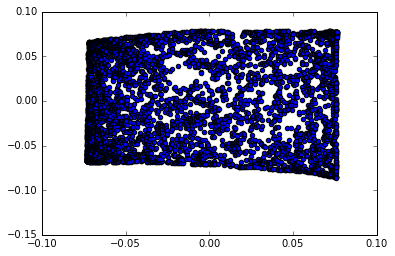

In [27]:
plt.scatter(e_vecs.T[1],e_vecs.T[2])

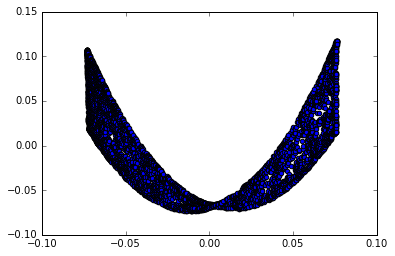

In [28]:
plt.scatter(e_vecs.T[1],e_vecs.T[3])

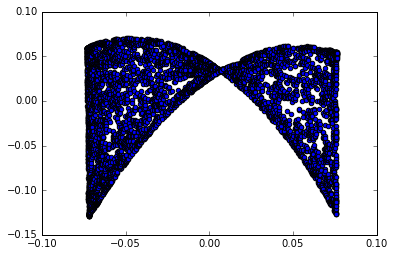

In [29]:
plt.scatter(e_vecs.T[1],e_vecs.T[4])

## Degenerate case, H = 30


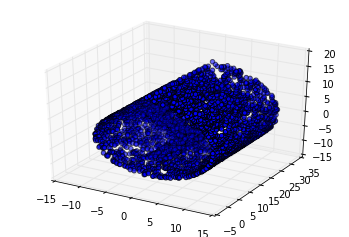

In [30]:
H = 30.
num_points = 5000

t = sorted([random.uniform(3.*np.pi/2., 9.*np.pi/2) for i in range(num_points)])
h = [random.uniform(0,H) for i in range(num_points)]
xs,ys,zs = list(t * np.cos(t)), list(h) , list(t * np.sin(t))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xs, ys, zs)

In [31]:
data = [[x,y,z] for x,y,z in zip(xs,ys,zs)]

params = {}
params["epsilon"] = 4. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 2. ## width of Gaussian kernel.
params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

params["data_size"] = num_points
params["eigen_dims"] = 5

e_vals, e_vecs = run_diffusion_map(data, params,True)

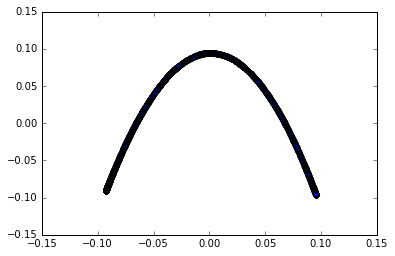

In [32]:
plt.scatter(e_vecs.T[1],e_vecs.T[2])

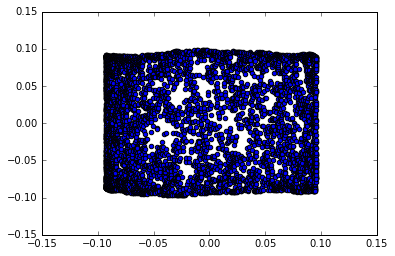

In [33]:
plt.scatter(e_vecs.T[1],e_vecs.T[3])

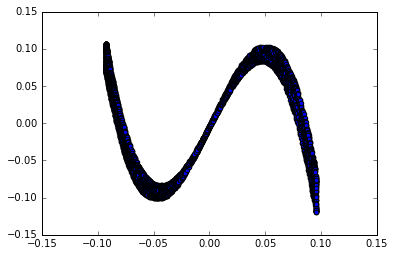

In [34]:
plt.scatter(e_vecs.T[1],e_vecs.T[4])

## Note: I used $\alpha = 1$ here to account for density, I do the 0.5 case below.

## Suggestion: compute mutual information between mutual coordinates to find degeneracy/redundancy. If a coordinate gives no information it can be left unused. Also, it seems like sometimes close eigenvectors get mixed. Taking a linear combination to minimize the mutual information might be an interesting idea.

## Degenerate case with $\alpha = 0.5$.

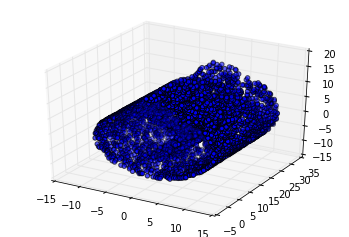

In [35]:
H = 30.
num_points = 5000

t = sorted([random.uniform(3.*np.pi/2., 9.*np.pi/2) for i in range(num_points)])
h = [random.uniform(0,H) for i in range(num_points)]
xs,ys,zs = list(t * np.cos(t)), list(h) , list(t * np.sin(t))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xs, ys, zs)

In [36]:
## Use alpha = 0.5 to see what happens

data = [[x,y,z] for x,y,z in zip(xs,ys,zs)]

params = {}
params["epsilon"] = 4. ## cutoff for nearest neighbors.
params["gaussian_epsilon"] = 2. ## width of Gaussian kernel.
params["alpha"] = 0.5 ## coefficient to use for diffusion maps. See the wikipedia article.

params["data_size"] = num_points
params["eigen_dims"] = 5

e_vals, e_vecs = run_diffusion_map(data, params,True)
print e_vals

[ 1.          0.99898989  0.99582992  0.99094191  0.99015702]


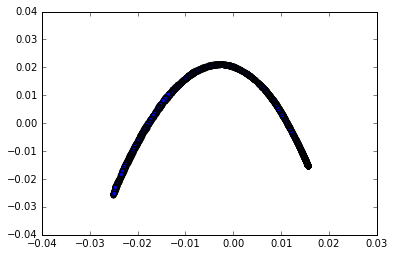

In [37]:
plt.scatter(e_vecs.T[1],e_vecs.T[2])

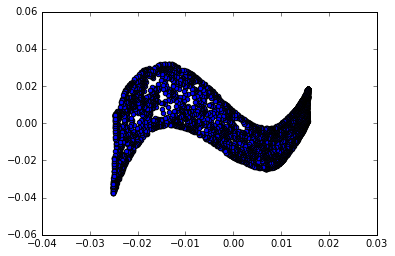

In [38]:
plt.scatter(e_vecs.T[1],e_vecs.T[3])

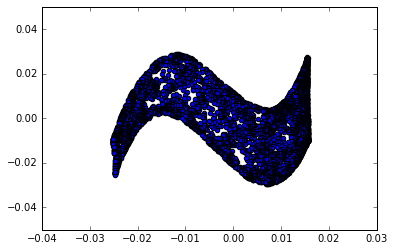

In [39]:
plt.scatter(e_vecs.T[1],e_vecs.T[4])

## It looks like the two degenerate vectors can be separated in some linear way (i.e. the last two diagrams above).

## Next, let's separate the degenerate eigenvectors using ICA.

In [40]:
min_eig = 3
max_eig = 4

In [41]:
X = e_vecs.T[min_eig:max_eig+1]

In [42]:
ica = FastICA(n_components=2)
S_ = ica.fit_transform(X.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix


In [43]:
A_ ## rotation of degenerate eigenspace

array([[-0.69410802,  0.72260997],
       [-0.7223    , -0.69460625]])

In [44]:
e_vecs_separated = np.asmatrix(e_vecs[:,min_eig:max_eig+1]) * A_

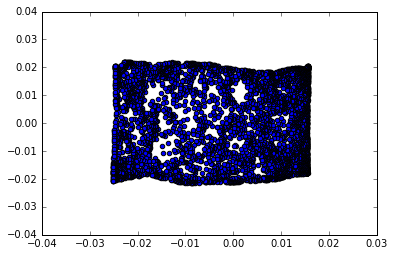

In [46]:
## one separated coordinate versus first coordinate

plt.scatter(e_vecs.T[1],np.asarray(e_vecs_separated.T[1])[0])

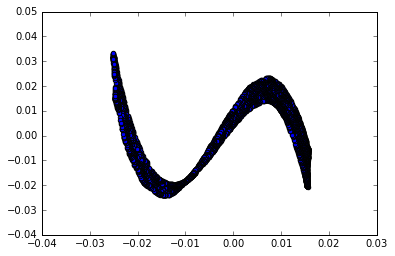

In [47]:
## second separated coordinate versus first coordinate

plt.scatter(e_vecs.T[1],np.asarray(e_vecs_separated.T[0])[0])